In [1]:
import math, random, time
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

In [2]:
CSV_PATH = "../../Data/btc_final_df.csv"

df = pd.read_csv(CSV_PATH)
df = df.drop(columns=['eth_to_btc_spill'])
if "timestamp" not in df.columns:
    raise ValueError("Expected a datetime column named 'timestamp' in the CSV.")
df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True, errors="coerce")
df = df.sort_values("timestamp").dropna(subset=["timestamp"]).reset_index(drop=True)

TARGET_CANDIDATES = ["vol_future", "target", "y"]
target_col = None
for c in TARGET_CANDIDATES:
    if c in df.columns:
        target_col = c
        break
if target_col is None:
    raise ValueError(f"Could not find a target column among {TARGET_CANDIDATES}. "
                     "Please rename your target to one of these or edit the list.")

feature_cols = [c for c in df.columns if c not in ["timestamp", target_col]]
num_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df[c])]
X_raw = df[["timestamp"] + num_cols].copy()
y_raw = df[["timestamp", target_col]].copy()

scaler_X = StandardScaler()
X_scaled = pd.DataFrame(
    scaler_X.fit_transform(X_raw[num_cols]),
    columns=num_cols,
    index=X_raw.index
)
X_raw_scaled = pd.concat([X_raw[["timestamp"]], X_scaled], axis=1)
X_raw = X_raw_scaled


In [3]:
n_total = len(X_raw)
split_idx = int(n_total * 0.85)
print(split_idx)
X_train_raw = X_raw[:split_idx]
y_train_raw = y_raw[:split_idx]
X_test_raw = X_raw[split_idx+1:]
y_test_raw = y_raw[split_idx+1:]

6976


In [4]:
def to_variance(arr, fmt="raw"):
    arr = np.asarray(arr, float)
    if fmt == "raw":        return arr
    if fmt == "log_sigma":  return np.exp(2.0*arr)
    if fmt == "log_var":    return np.exp(arr)
    raise ValueError

In [5]:
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=10000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))  
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

# -----------------------------
# Random Synthesizer Attention
# -----------------------------

class MultiheadRandomSynthesizer(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, attn_dropout: float = 0.1, causal: bool = False):
        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(attn_dropout)
        self.causal = causal

        self.v_proj = nn.Linear(embed_dim, embed_dim, bias=False)

    def _shape(self, x: torch.Tensor, B: int, L: int) -> torch.Tensor:
        return x.view(B, L, self.num_heads, self.head_dim).transpose(1, 2).contiguous()

    def forward(
        self,
        x: torch.Tensor,
        key_padding_mask: Optional[torch.Tensor] = None,
        need_weights: bool = False,
        attn_mask: Optional[torch.Tensor] = None,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        B, L, D = x.size()
        V = self._shape(self.v_proj(x), B, L) 

        rand_logits = torch.rand(B, self.num_heads, L, L, device=x.device, dtype=x.dtype)

        if self.causal:
            causal_mask = torch.triu(torch.ones(L, L, device=x.device, dtype=torch.bool), diagonal=1)
            rand_logits = rand_logits.masked_fill(causal_mask, float("-inf"))

        if attn_mask is not None:
            rand_logits = rand_logits.masked_fill(attn_mask.bool().unsqueeze(0).unsqueeze(0), float("-inf"))

        if key_padding_mask is not None:
            kpm = key_padding_mask.bool().unsqueeze(1).unsqueeze(1)  # [B,1,1,L]
            rand_logits = rand_logits.masked_fill(kpm, float("-inf"))

        attn = F.softmax(rand_logits, dim=-1) 
        attn = self.dropout(attn)

        out = torch.matmul(attn, V)  
        out = out.transpose(1, 2).contiguous().view(B, L, D) 
        out = self.out_proj(out)

        return out, (attn if need_weights else None)


# -------------------------------------
# Encoder Layer using Random Synthesizer
# -------------------------------------

class RandomSynthesizerEncoderLayer(nn.Module):
    def __init__(
        self,
        d_model: int,
        nhead: int,
        dim_feedforward: int = 256,
        dropout: float = 0.1,
        attn_dropout: float = 0.1,
        causal: bool = False,
        layer_norm_eps: float = 1e-5,
    ):
        super().__init__()
        self.self_attn = MultiheadRandomSynthesizer(
            embed_dim=d_model,
            num_heads=nhead,
            attn_dropout=attn_dropout,
            causal=causal,
        )
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.norm2 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(
        self,
        src: torch.Tensor,                     
        src_key_padding_mask: Optional[torch.Tensor] = None,  
        need_weights: bool = False,
    ):
        attn_out, attn_w = self.self_attn(src, key_padding_mask=src_key_padding_mask, need_weights=need_weights)
        src = src + self.dropout1(attn_out)
        src = self.norm1(src)

        ffn = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(ffn)
        src = self.norm2(src)

        return src, attn_w


# -----------------------------
# Random Synthesizer Transformer
# -----------------------------

class RandomSynthesizerTransformer(nn.Module):
    def __init__(
        self,
        input_dim: int,
        d_model: int = 96,
        nhead: int = 2,
        num_layers: int = 1,
        dim_feedforward: int = 384,
        dropout: float = 0.1,
        attn_dropout: float = 0.1,
        causal: bool = False,
        out_dim: int = 1,
    ):
        super().__init__()
        self.in_proj = nn.Linear(input_dim, d_model)
        self.layers = nn.ModuleList([
            RandomSynthesizerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                attn_dropout=attn_dropout,
                causal=causal,
            )
            for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)
        self.out_head = nn.Linear(d_model, out_dim)

    def forward(
        self,
        x: torch.Tensor,                        
        key_padding_mask: Optional[torch.Tensor] = None,  
        return_attn: bool = False,
    ):
        attns = []
        h = self.in_proj(x)                      
        for layer in self.layers:
            h, a = layer(h, src_key_padding_mask=key_padding_mask, need_weights=return_attn)
            if return_attn:
                attns.append(a)

        last = h[:, -1, :]                       
        y = self.out_head(self.dropout(last))    
        return (y, attns) if return_attn else y


# -----------------------------
# Tiny glue to integrate quickly
# -----------------------------

@dataclass
class TrainConfig:
    seq_len: int = 1
    batch_size: int = 8
    lr: float = 3e-4
    weight_decay: float = 1e-4
    max_epochs: int = 60
    patience: int = 6
    d_model: int = 96
    nhead: int = 2
    num_layers: int = 1
    dim_feedforward: int = 384
    dropout: float = 0.3
    attn_dropout: float = 0.1
    causal: bool = False

def build_model_random_synth(input_dim: int, cfg: TrainConfig, out_dim: int = 1) -> nn.Module:
    return RandomSynthesizerTransformer(
        input_dim=input_dim,
        d_model=cfg.d_model,
        nhead=cfg.nhead,
        num_layers=cfg.num_layers,
        dim_feedforward=cfg.dim_feedforward,
        dropout=cfg.dropout,
        attn_dropout=cfg.attn_dropout,
        causal=cfg.causal,
        out_dim=out_dim,
    )


In [6]:
def _quick_diag(tag, yv_true, yv_pred):
    print(f"[{tag}] y_true mean={yv_true.mean():.4g} std={yv_true.std():.4g} | "
          f"y_pred mean={yv_pred.mean():.4g} std={yv_pred.std():.4g} | "
          f"uniq_pred≈{np.unique(np.round(yv_pred,6)).size}")

In [7]:
# ---------- Metrics ----------
def rmse(y_true, y_pred): 
    return math.sqrt(mean_squared_error(y_true, y_pred))

def rmpse(y_true, y_pred, eps: float = 1e-8):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    pct = ((y_pred - y_true) / (np.abs(y_true) + eps))**2
    return float(np.sqrt(np.mean(pct)))

def qlike_variance(v_true, v_pred, eps: float = 1e-12) -> float:
    v_true = np.asarray(v_true, dtype=float)
    v_pred = np.asarray(v_pred, dtype=float)
    v_true = np.maximum(v_true, eps)
    v_pred = np.maximum(v_pred, eps)
    ratio = v_true / v_pred
    return float(np.mean(ratio - np.log(ratio) - 1.0))

# ---------- Dataset ----------
class SeqDataset(Dataset):
    def __init__(self, X_seq: np.ndarray, y_seq: np.ndarray):
        self.X = torch.tensor(X_seq, dtype=torch.float32)
        self.y = torch.tensor(y_seq, dtype=torch.float32).view(-1, 1)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

# ---------- Windowing ----------
def make_sequences(X_df: pd.DataFrame, y_df: pd.DataFrame, seq_len: int
                  ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    assert np.all(X_df["timestamp"].values == y_df["timestamp"].values)
    X_values = X_df.drop(columns=["timestamp"]).values
    y_values = y_df.drop(columns=["timestamp"]).values.squeeze(-1)
    times = X_df["timestamp"].values

    X_seq, y_seq, t_seq = [], [], []
    for i in range(seq_len, len(X_values)):
        X_seq.append(X_values[i - seq_len + 1 : i + 1, :])
        y_seq.append(y_values[i])
        t_seq.append(times[i])
    return np.array(X_seq), np.array(y_seq), np.array(t_seq)

# ---------- Time splits with purge ----------
def build_rolling_folds(t_seq: np.ndarray, n_folds: int = 5, purge_hours: int = 1):
    t = pd.to_datetime(t_seq)
    N = len(t)
    if N < n_folds + 1:
        raise ValueError(f"Not enough samples ({N}) for {n_folds} folds.")

    # Start boundaries at 1 (not 0) so the first fold has a non-empty train
    boundaries = np.linspace(1, N, n_folds + 1, dtype=int)

    folds = []
    for k in range(n_folds):
        train_end = boundaries[k]         
        valid_end = boundaries[k + 1]  

        # purge between training and validation
        purge_until = t[train_end - 1] + pd.Timedelta(hours=purge_hours)
        start_val = train_end
        while start_val < valid_end and t[start_val] < purge_until:
            start_val += 1

        train_idx = np.arange(0, train_end)
        valid_idx = np.arange(start_val, valid_end)

        if len(valid_idx) == 0:
            continue

        folds.append({"train_idx": train_idx, "valid_idx": valid_idx})

    if len(folds) < n_folds:
        raise ValueError(
            f"Produced {len(folds)} folds, not {n_folds}. "
            "Likely the purge window fully removed a validation slice; "
            "reduce purge_hours or use fewer folds."
        )
    return folds

# ---------- Training helpers ----------
def train_one_epoch(model, loader, optim, loss_fn):
    model.train()
    total = 0.0; n = 0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optim.zero_grad(); loss.backward(); optim.step()
        total += loss.item() * len(xb); n += len(xb)
    return total / max(n,1)

@torch.no_grad()
def eval_epoch(model, loader, loss_fn):
    model.eval()
    y_true, y_pred = [], []
    total = 0.0; n = 0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        total += loss.item() * len(xb); n += len(xb)
        y_true.append(yb.detach().cpu().numpy().ravel())
        y_pred.append(pred.detach().cpu().numpy().ravel())
    y_true = np.concatenate(y_true) if y_true else np.array([])
    y_pred = np.concatenate(y_pred) if y_pred else np.array([])
    return (total / max(n,1)), y_true, y_pred

def early_stop_train(model, train_loader, val_loader, cfg, verbose=False):
    loss_fn = nn.MSELoss()
    optim = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    best_val = float("inf"); best_state = None; patience_left = cfg.patience
    for epoch in range(cfg.max_epochs):
        _ = train_one_epoch(model, train_loader, optim, loss_fn)
        val_loss, yv_true, yv_pred = eval_epoch(model, val_loader, loss_fn)
        if val_loss < best_val - 1e-8:
            best_val = val_loss; best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
            patience_left = cfg.patience
        else:
            patience_left -= 1
            if patience_left <= 0:
                break
    if best_state is not None:
        model.load_state_dict(best_state)
    return model

# ---------- Config + Search Space ----------

SEARCH_SPACE = {
    "seq_len":         [1],
    "batch_size":      [8, 32, 64, 128],
    "lr":              [1e-3, 3e-4, 1e-4],
    "weight_decay":    [1e-5, 1e-4, 3e-4],
    "d_model":         [64, 96, 128],
    "nhead":           [2, 4, 8],
    "num_layers":      [1, 2, 3],
    "dim_feedforward": [128, 256, 384],
    "dropout":         [0.1, 0.2, 0.3],
    "max_epochs":      [40, 60],
    "patience":        [6, 8],
    "attn_dropout":    [0.0, 0.1],

}

def sample_cfg() -> TrainConfig:
    def s(k): return random.choice(SEARCH_SPACE[k])
    return TrainConfig(
        seq_len=s("seq_len"),
        batch_size=s("batch_size"),
        lr=s("lr"),
        weight_decay=s("weight_decay"),
        d_model=s("d_model"),
        nhead=s("nhead"),
        num_layers=s("num_layers"),
        dim_feedforward=s("dim_feedforward"),
        dropout=s("dropout"),
        attn_dropout=s("attn_dropout"),
        patience=s("patience"),
        max_epochs=s("max_epochs"),
        causal=False,
    )

# ---------- Orchestration ----------
def run_cv_random_synth(X_df: pd.DataFrame,
                        y_df: pd.DataFrame,
                        n_folds: int = 5,
                        purge_hours: int = 1,
                        n_trials: int = 25,
                        metric_for_early_select: str = "rmse"  
                       ):
    cv_records = []
    best_score = float("inf")
    best_cfg = None
    best_trial_metrics = None

    for trial in range(1, n_trials+1):
        cfg = sample_cfg()
        print(f"\n{'='*50}")
        print(f"🧪 Trial {trial:02d} Hyperparameters")
        print(f"{'-'*50}")
        for k, v in vars(cfg).items():
            print(f"{k:<15}: {v}")
            print(f"{'='*50}\n")


        X_seq, y_seq, t_seq = make_sequences(X_df, y_df, seq_len=cfg.seq_len)
        folds = build_rolling_folds(t_seq, n_folds=n_folds, purge_hours=purge_hours)
        if len(folds) == 0:
            raise ValueError("No valid folds produced. Check timestamps / seq_len.")

        fold_metrics = []
        for k, f in enumerate(folds, 1):
            tr_idx, va_idx = f["train_idx"], f["valid_idx"]
            X_tr, y_tr = X_seq[tr_idx], y_seq[tr_idx]
            X_va, y_va = X_seq[va_idx], y_seq[va_idx]

            tr_loader = DataLoader(SeqDataset(X_tr, y_tr), batch_size=cfg.batch_size, shuffle=True, drop_last=False)
            va_loader = DataLoader(SeqDataset(X_va, y_va), batch_size=cfg.batch_size, shuffle=False, drop_last=False)

            model = build_model_random_synth(input_dim=X_seq.shape[-1], cfg=cfg, out_dim=1).to(DEVICE)
            model = early_stop_train(model, tr_loader, va_loader, cfg)

            _, yv_true, yv_pred = eval_epoch(model, va_loader, nn.MSELoss())

            _quick_diag(f"trial{trial}_fold{k}", yv_true, yv_pred)
            if k == 1:
                print("sample preds:", np.round(yv_pred[:10], 6))

            v_true = yv_true
            v_pred = np.maximum(yv_pred, 1e-8)
            v_true = to_variance(v_true, fmt="raw")   
            v_pred = to_variance(v_pred, fmt="raw")   

            fold_res = {
                "rmse": rmse(v_true, v_pred),
                "rmpse": rmpse(v_true, v_pred),
                "qlike": qlike_variance(v_true, v_pred),
            }
            fold_metrics.append(fold_res)

        avg = {m: float(np.mean([fm[m] for fm in fold_metrics])) for m in ["rmse","rmpse","qlike"]}
        rec = {"trial": trial, **avg, **cfg.__dict__}
        cv_records.append(rec)

        key = metric_for_early_select
        score = avg[key]
        if score < best_score:
            best_score = score
            best_cfg = cfg
            best_trial_metrics = {"per_fold": fold_metrics, "avg": avg}

        print(f"[Trial {trial:02d}] mean RMSE={avg['rmse']:.6f} QLIKE={avg['qlike']:.6f}  <- {'BEST' if score==best_score else ''}")

    cv_summary = pd.DataFrame(cv_records).sort_values(metric_for_early_select, ascending=True).reset_index(drop=True)
    return best_cfg, cv_summary, best_trial_metrics

# ---------- Final Train on full train span ----------
def train_on_timespan(
    X_df: pd.DataFrame,
    y_df: pd.DataFrame,
    cfg: TrainConfig,
    train_until_time: Optional[pd.Timestamp] = None,
    purge_hours: int = 1,   
):
    X_seq, y_seq, t_seq = make_sequences(X_df, y_df, seq_len=cfg.seq_len)
    t_seq = pd.to_datetime(t_seq)

    if train_until_time is None:
        split_idx = int(len(X_seq) * 0.85)
        tr_idx = np.arange(0, split_idx)
        te_idx = np.arange(split_idx, len(X_seq))
    else:
        cut = pd.Timestamp(train_until_time)
        tr_idx = np.where(t_seq <= cut)[0]
        te_idx = np.where(t_seq >  cut)[0]

    if len(tr_idx) > 0 and len(te_idx) > 0:
        purge_until = t_seq[tr_idx[-1]] + pd.Timedelta(hours=purge_hours)
        te_idx = te_idx[t_seq[te_idx] >= purge_until]
    else:
        purge_until = None  

    # Final sanity checks
    if len(tr_idx) == 0:
        raise ValueError("No training samples available after split. Check 'train_until_time' or seq_len.")
    if len(te_idx) == 0:
        raise ValueError(
            f"No test samples after applying a {purge_hours}h purge. "
            "Reduce purge_hours, adjust 'train_until_time', or change the split."
        )

    print(
        f"Train n={len(tr_idx)} (end @ {t_seq[tr_idx[-1]]}) | "
        f"Test n={len(te_idx)} (start @ {t_seq[te_idx[0]]}) | "
        f"Purge={purge_hours}h"
    )

    X_tr, y_tr = X_seq[tr_idx], y_seq[tr_idx]
    X_te, y_te = X_seq[te_idx], y_seq[te_idx]

    split_tr = int(len(X_tr) * 0.85)
    X_tr2, y_tr2 = X_tr[:split_tr], y_tr[:split_tr]
    X_val,  y_val  = X_tr[split_tr:], y_tr[split_tr:]

    tr_loader = DataLoader(SeqDataset(X_tr2, y_tr2), batch_size=cfg.batch_size, shuffle=True)
    val_loader = DataLoader(SeqDataset(X_val,  y_val),  batch_size=cfg.batch_size, shuffle=False)
    te_loader  = DataLoader(SeqDataset(X_te,   y_te),   batch_size=cfg.batch_size, shuffle=False)

    model = build_model_random_synth(input_dim=X_seq.shape[-1], cfg=cfg, out_dim=1).to(DEVICE)
    model = early_stop_train(model, tr_loader, val_loader, cfg)   # <— use val, not test

    _, y_true, y_pred = eval_epoch(model, te_loader, nn.MSELoss())
    v_true = y_true
    v_pred = np.maximum(y_pred, 1e-8)
    v_true = to_variance(v_true, fmt="log_sigma")
    v_pred = to_variance(v_pred, fmt="log_sigma")

    metrics = {
        "RMSE": rmse(v_true, v_pred),
        "RMPSE": rmpse(v_true, v_pred),
        "QLIKE": qlike_variance(v_true, v_pred),
        "n_test": int(len(v_true)),
        "purge_hours": purge_hours,
        "train_end_time": t_seq[tr_idx[-1]],
        "test_start_time": t_seq[te_idx[0]],
    }
    return model, (v_true, v_pred, t_seq[te_idx]), metrics


In [8]:
# Hyperparameter tuning with 5-fold purged rolling CV (
best_cfg, cv_table, best_cv = run_cv_random_synth(
    X_df=X_train_raw, y_df=y_train_raw,
    n_folds=5, purge_hours=1,
    n_trials=20,                  
    metric_for_early_select="rmse" 
)

print("Best config:", best_cfg)
display(cv_table.head(10))


🧪 Trial 01 Hyperparameters
--------------------------------------------------
seq_len        : 1

batch_size     : 8

lr             : 0.0001

weight_decay   : 0.0001

max_epochs     : 40

patience       : 8

d_model        : 64

nhead          : 2

num_layers     : 1

dim_feedforward: 384

dropout        : 0.1

attn_dropout   : 0.0

causal         : False

[trial1_fold1] y_true mean=-4.761 std=0.4868 | y_pred mean=-1.025 std=0.7175 | uniq_pred≈1394
sample preds: [-1.583401 -2.157712 -1.568874 -1.663292 -1.742087 -1.393079 -1.838962
 -1.923342 -1.675147 -1.888332]
[trial1_fold2] y_true mean=-4.928 std=0.4914 | y_pred mean=-5.101 std=0.3755 | uniq_pred≈1394
[trial1_fold3] y_true mean=-4.928 std=0.6688 | y_pred mean=-5.05 std=0.5215 | uniq_pred≈1395
[trial1_fold4] y_true mean=-5.466 std=0.6019 | y_pred mean=-5.474 std=0.443 | uniq_pred≈1392
[trial1_fold5] y_true mean=-5.592 std=0.5186 | y_pred mean=-5.809 std=0.4072 | uniq_pred≈1395
[Trial 01] mean RMSE=5.169237 QLIKE=8.470741  <- BEST


,trial,rmse,rmpse,qlike,seq_len,batch_size,lr,weight_decay,max_epochs,patience,d_model,nhead,num_layers,dim_feedforward,dropout,attn_dropout,causal
0,1,5.169237,1.000878,8.470741,1,8,0.0001,0.00010,40,8,64,2,1,384,0.1,0.0,False
1,9,5.173680,1.001806,8.374840,1,128,0.0010,0.00010,60,8,64,2,3,384,0.3,0.1,False
2,20,5.173886,1.001856,8.343152,1,64,0.0010,0.00001,60,6,64,2,3,256,0.1,0.1,False
3,15,5.175233,1.002173,8.481325,1,128,0.0001,0.00001,60,8,96,8,3,256,0.1,0.0,False
4,17,5.177005,1.002599,8.711734,1,8,0.0001,0.00030,60,6,64,2,1,128,0.2,0.0,False
5,12,5.179752,1.003158,8.535952,1,64,0.0003,0.00001,60,6,96,2,3,384,0.2,0.0,False
6,4,5.186444,1.004383,8.681573,1,8,0.0003,0.00010,40,8,128,4,1,384,0.2,0.0,False
7,19,5.192497,1.005842,9.167770,1,8,0.0001,0.00010,40,6,96,4,2,256,0.3,0.0,False
8,7,5.193653,1.005918,8.498580,1,32,0.0010,0.00010,40,8,96,4,3,384,0.3,0.0,False
9,11,5.194567,1.006269,8.812914,1,128,0.0001,0.00010,60,8,128,4,3,128,0.3,0.0,False


In [9]:
cutoff_time = pd.Timestamp("2025-08-22 16:00:00")
final_model, (y_true, y_pred, t_test), test_metrics = train_on_timespan(
    X_df=X_raw, y_df=y_raw, cfg=best_cfg, train_until_time=cutoff_time
)
print("Test metrics:", test_metrics)
print((y_true, y_pred, t_test))




Train n=6976 (end @ 2025-08-22 16:00:00) | Test n=1231 (start @ 2025-08-22 17:00:00) | Purge=1h
Test metrics: {'RMSE': 0.9999640712430109, 'RMPSE': 518842.9156500553, 'QLIKE': 10.851182186856846, 'n_test': 1231, 'purge_hours': 1, 'train_end_time': Timestamp('2025-08-22 16:00:00'), 'test_start_time': Timestamp('2025-08-22 17:00:00')}
(array([4.75314157e-05, 1.15184762e-05, 6.59165818e-06, ...,
       4.32570499e-05, 4.04740292e-05, 5.29079833e-07]), array([1.00000002, 1.00000002, 1.00000002, ..., 1.00000002, 1.00000002,
       1.00000002]), DatetimeIndex(['2025-08-22 17:00:00', '2025-08-22 18:00:00',
               '2025-08-22 19:00:00', '2025-08-22 20:00:00',
               '2025-08-22 21:00:00', '2025-08-22 22:00:00',
               '2025-08-22 23:00:00', '2025-08-23 00:00:00',
               '2025-08-23 01:00:00', '2025-08-23 02:00:00',
               ...
               '2025-10-12 14:00:00', '2025-10-12 15:00:00',
               '2025-10-12 16:00:00', '2025-10-12 17:00:00',
        

In [10]:
pred_df = pd.DataFrame({"timestamp": pd.to_datetime(t_test), "observed": y_true, "predicted": y_pred})
pred_df.to_csv("../../Results/btc_transformer_random_prediction.csv", index=False)


Plotting the result 

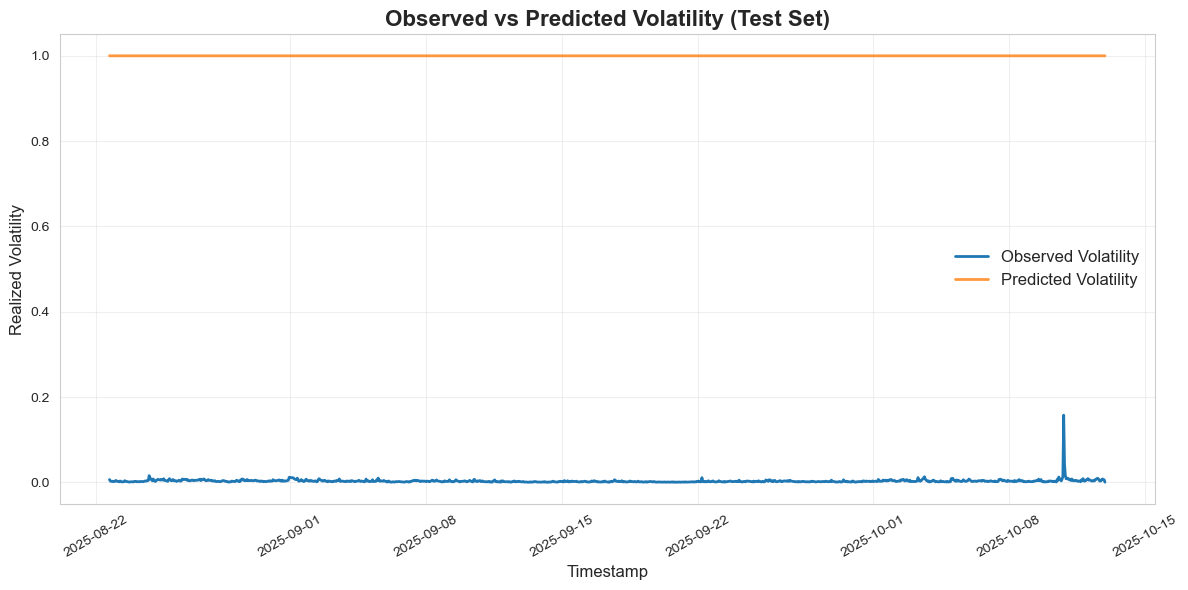

In [11]:
import seaborn as sns

# Ensure timestamp is datetime and sorted
pred_df = pred_df.sort_values("timestamp")
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
obs_v = np.sqrt(pred_df["observed"])
pred_v = np.sqrt(pred_df["predicted"])



# Plot observed vs predicted
plt.plot(pred_df["timestamp"], obs_v, 
         label="Observed Volatility", linewidth=2, color="#1f77b4")
plt.plot(pred_df["timestamp"], pred_v, 
         label="Predicted Volatility", linewidth=2, color="#ff7f0e", alpha=0.8)

# Formatting
plt.title("Observed vs Predicted Volatility (Test Set)", fontsize=16, weight="bold")
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Realized Volatility", fontsize=12)
plt.legend(frameon=False, fontsize=12)
plt.xticks(rotation=30)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Feature Importance 

In [12]:
X_seq, y_seq, t_seq = make_sequences(X_raw, y_raw, seq_len=best_cfg.seq_len)
t_seq = pd.to_datetime(t_seq)

mask = t_seq > cutoff_time
X_test = X_seq[mask]
y_test = y_seq[mask]

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_model.to(DEVICE)
final_model.eval()


RandomSynthesizerTransformer(
  (in_proj): Linear(in_features=25, out_features=64, bias=True)
  (layers): ModuleList(
    (0): RandomSynthesizerEncoderLayer(
      (self_attn): MultiheadRandomSynthesizer(
        (out_proj): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (v_proj): Linear(in_features=64, out_features=64, bias=False)
      )
      (linear1): Linear(in_features=64, out_features=384, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=384, out_features=64, bias=True)
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (activation): ReLU()
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (out_head): Linear(in_features=64, out_features=1, bias=True)
)

In [13]:
xb_sample = torch.tensor(X_test[-10:], dtype=torch.float32).to(DEVICE)

def forward_fn(x):
    return final_model(x).squeeze(1)

ig = IntegratedGradients(forward_fn)
attributions, delta = ig.attribute(
    xb_sample,
    target=None,
    n_steps=50,
    return_convergence_delta=True
)

attr_mean = attributions.mean(dim=(0,1)).detach().cpu().numpy()
attr_abs = np.abs(attr_mean)  

feat_importance = pd.DataFrame({
    "feature": num_cols,
    "importance": attr_abs
}).sort_values("importance", key=np.abs, ascending=False)


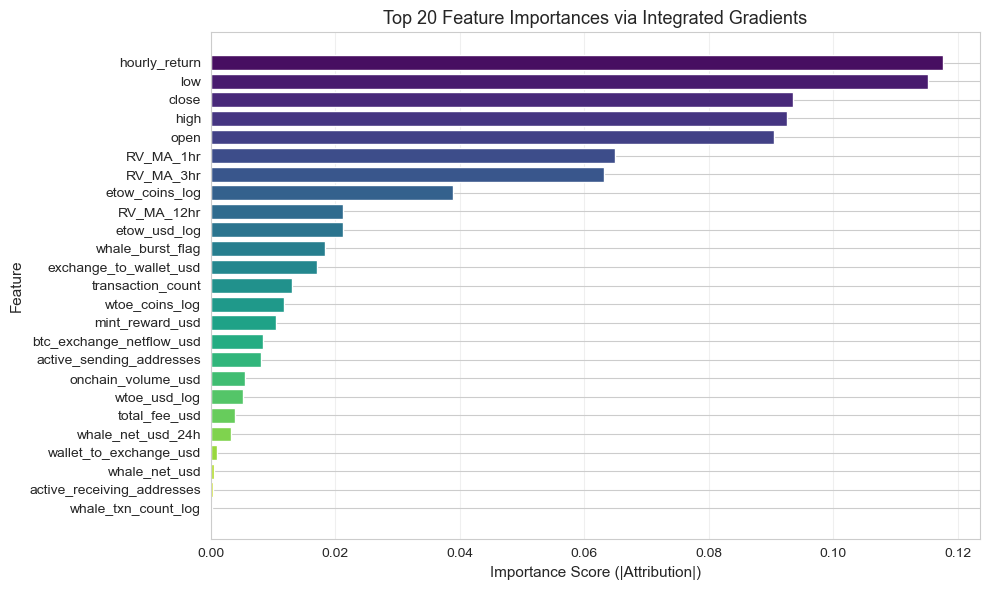

In [14]:
plt.figure(figsize=(10, 6))
colors = sns.color_palette("viridis", len(feat_importance))
plt.barh(feat_importance["feature"][::-1], feat_importance["importance"][::-1], color=colors[::-1])
plt.title("Top 20 Feature Importances via Integrated Gradients", fontsize=13)
plt.xlabel("Importance Score (|Attribution|)", fontsize=11)
plt.ylabel("Feature", fontsize=11)
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()
